## EXAMPLE QUANTITATIVE RESEARCH FOR LONG / SHORT PAIRS TRADING IN CRYPTO CURRENCIES

### Preliminary 
The data is pulled from BitStamp using the scipt data.py

### Basic Thesis
The basic idea of any pairs trading strategy is that some assets move together. Sometimes, one in a pair of assets that generally move together, will diverge away from the other in the pair but only to revert back. These swings away and back to each other can be traded on. In this example, we look at BTC and ETH. The basic thesis is that the two generally move together and divergences from each other are followed by a reversion. 



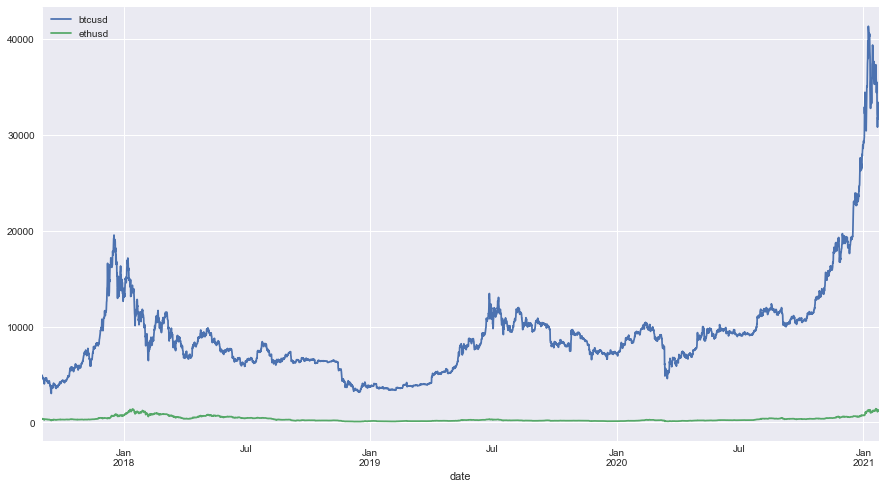

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

df = pd.read_csv('prices.csv', index_col='date')
df.index = pd.to_datetime(df.index)

df.plot(figsize=(15,8))

Very hard to learn anything from this plot as the price of BTC is much higher than ETH and so it is not at all easy to see how the two move together. We can instead compute and plot the cumulative returns over time to get an idea of how one dollar in each would grow throughout the sample.

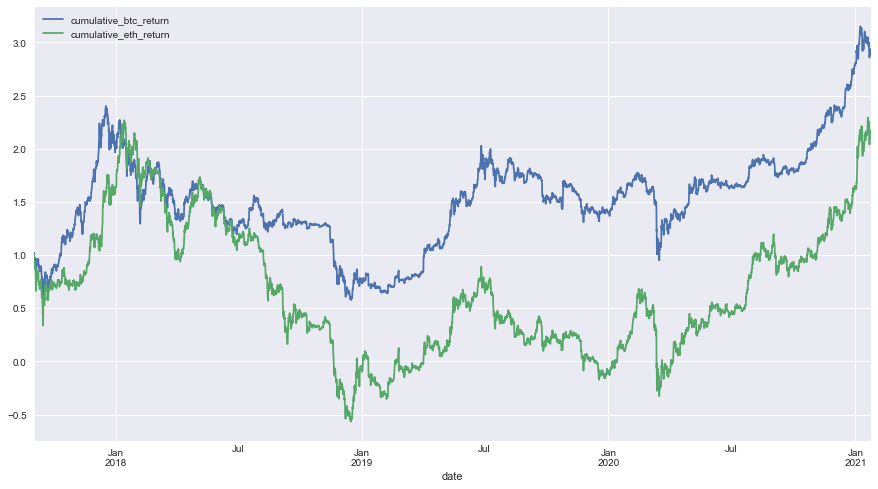

In [7]:
df['btcreturn'] = np.log(df['btcusd']) - np.log(df['btcusd'].shift(1))
df['ethreturn'] = np.log(df['ethusd']) - np.log(df['ethusd'].shift(1))

df.dropna(inplace=True)

df['cumulative_btc_return'] = 1 + np.cumsum(df['btcreturn'])
df['cumulative_eth_return'] = 1 + np.cumsum(df['ethreturn'])

df[['cumulative_btc_return', 'cumulative_eth_return']].plot(figsize=(15,8))

Definitely seems like the two coins move somewhat in tandem. One way to quantify the relative distance between the two coins in any given time is to take the ratio of the price of BTC to the price of ETH

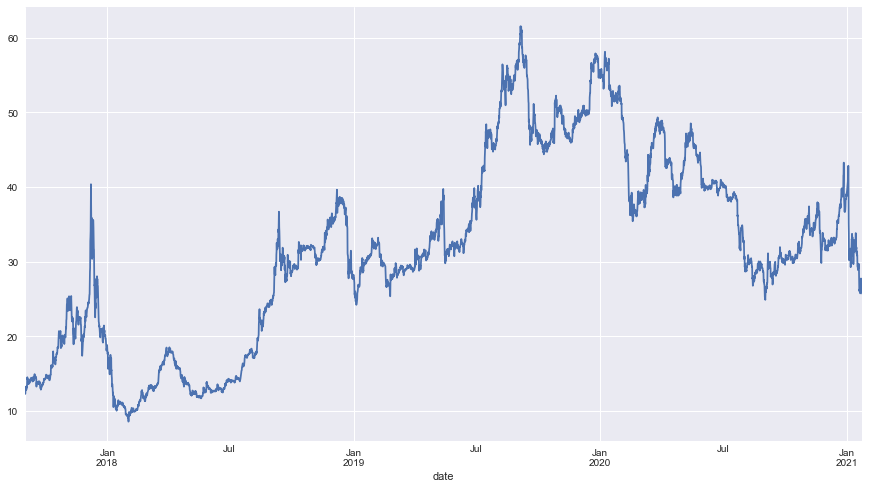

In [8]:
df['price_ratio'] = df['btcusd'] / df['ethusd']
df['price_ratio'].plot(figsize=(15,8))

There seems to be some indication of mean reversion in this ratio, over several years. Not overly interesting if we seek to attain superior performance by actively trading. Perhaps the ratio of cumulative returns is more suited as a signal we can trade on?

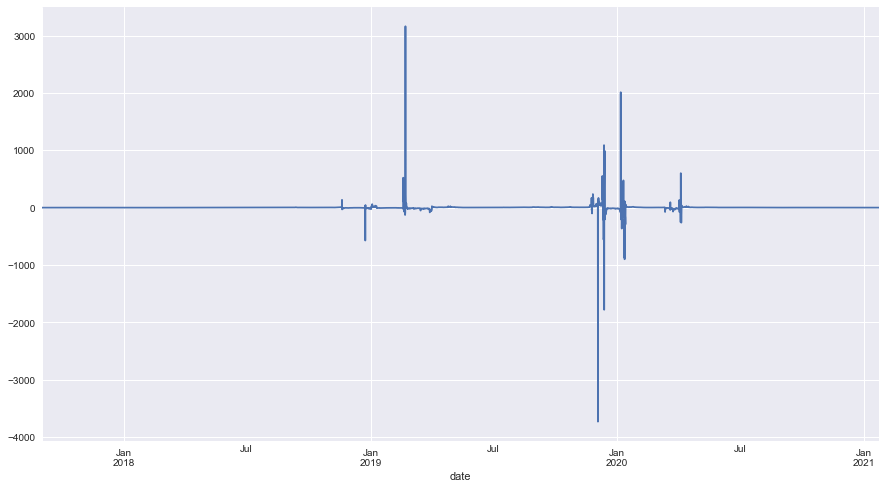

In [9]:
df['return_ratio'] = df['cumulative_btc_return'] / df['cumulative_eth_return']
df['return_ratio'].plot(figsize=(15,8))

This looks even less useful. However, something interesting happens when we (kind of) invoke the central limit theorem and standardize these two series and plot them again.

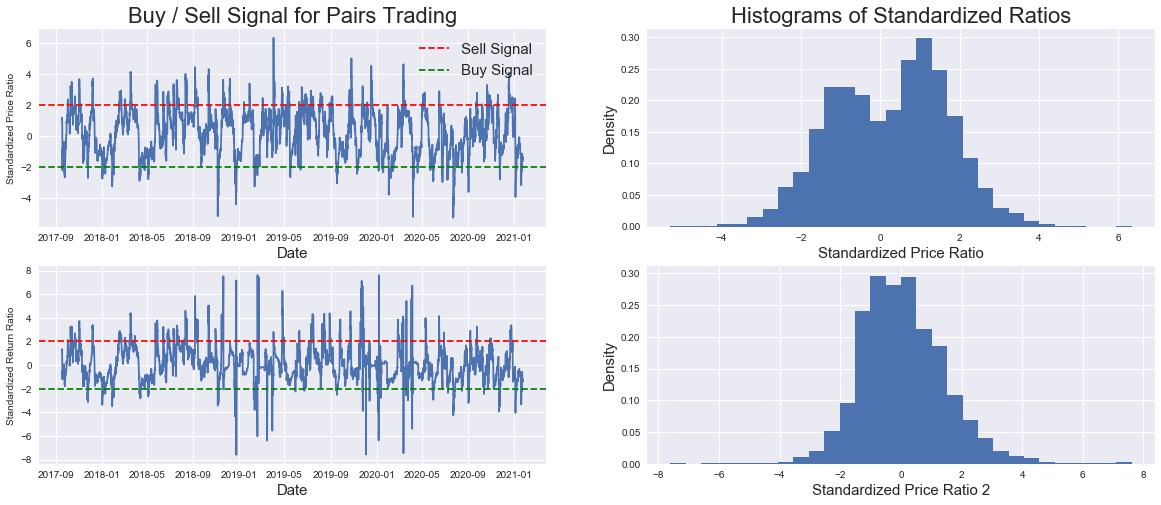

In [10]:
lb = 60
df['standardized_price_ratio_1'] = (df['price_ratio'] - df['price_ratio'].rolling(window=lb).mean()) / df['price_ratio'].rolling(window=lb).std()
df['standardized_return_ratio_2'] = (df['return_ratio'] - df['return_ratio'].rolling(window=lb).mean()) / df['return_ratio'].rolling(window=lb).std()

df.dropna(inplace=True)

fig, axs = plt.subplots(2,2,figsize=(20,8))
axs[0,0].plot(df.index, df['standardized_price_ratio_1'])
axs[0,0].axhline(y=2, color='r', linestyle='--' , label='Sell Signal')
axs[0,0].axhline(y=-2, color='g', linestyle='--', label='Buy Signal')
axs[0,0].set_xlabel('Date', fontsize=15)
axs[0,0].set_ylabel('Standardized Price Ratio', fontsize=10)
axs[0,0].set_title('Buy / Sell Signal for Pairs Trading', fontsize=22)
axs[0,0].legend(prop={'size':15})

axs[1,0].plot(df.index, df['standardized_return_ratio_2'])
axs[1,0].axhline(y=2, color='r', linestyle='--' , label='Sell Signal')
axs[1,0].axhline(y=-2, color='g', linestyle='--', label='Buy Signal')
axs[1,0].set_xlabel('Date', fontsize=15)
axs[1,0].set_ylabel('Standardized Return Ratio', fontsize=10)

axs[0,1].hist(df['standardized_price_ratio_1'], bins=30, density=True)
axs[0,1].set_xlabel('Standardized Price Ratio', fontsize=15)
axs[0,1].set_ylabel('Density', fontsize=15)
axs[0,1].set_title('Histograms of Standardized Ratios', fontsize=22)

axs[1,1].hist(df['standardized_return_ratio_2'], bins=30, density=True)
axs[1,1].set_xlabel('Standardized Price Ratio 2', fontsize=15)
axs[1,1].set_ylabel('Density', fontsize=15)


plt.show()

We end up that looks much more like a tradeable signal. We can see both series bouncing around a somewhat stable long-term average of 0. The idea now is that when the series is above some threshold (that has been set arbitrarily), BTC is relatively expensive compared to ETH and likely to fall. When the series is below a likewise arbitrary threshold, BTC is relatively cheap compared to ETH and likely to rise in value. When BTC is relatively expensive, we should try to short it and use the proceeds to go long in ETH. Likewise, when BTC is relatively cheap, we should try to short ETH and use the proceeds to go long in BTC. For demonstration purposes, we should try to trade on both of the signals (albeit not at the same time).

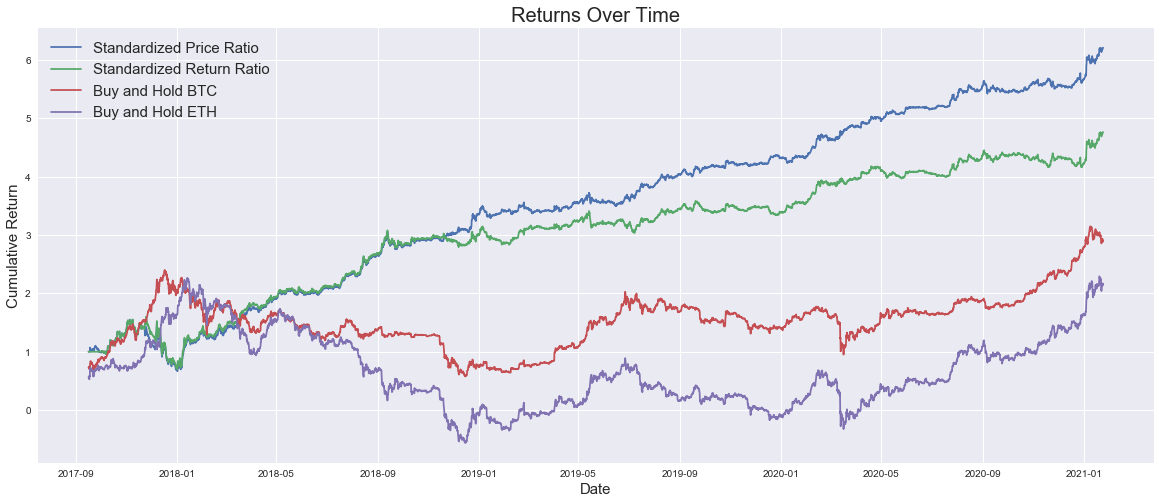

In [12]:
df['long_btc_signal_1'] = np.where(df['standardized_price_ratio_1'] <= -2, 1, 0)
df['short_btc_signal_1'] = np.where(df['standardized_price_ratio_1'] >= 2, -1, 0)
df['long_short_return_1'] = 0
df['position_1'] = 0

df['long_btc_signal_2'] = np.where(df['standardized_return_ratio_2'] <= -2, 1, 0)
df['short_btc_signal_2'] = np.where(df['standardized_return_ratio_2'] >= 2, -1, 0)
df['long_short_return_2'] = 0
df['position_2'] = 0

pd.set_option('mode.chained_assignment', None)

# This is not very Pythonic and generally not a good way of doing things
for i in range(len(df)):
    
    if i == 0:
        
        if (df['long_btc_signal_1'][i] == 0 and df['short_btc_signal_1'][i] == 0):
            df['position_1'][i] = 0
    else:
        
        if (df['long_btc_signal_1'][i] == 0 and df['short_btc_signal_1'][i] == 0):
            df['position_1'][i] = df['position_1'][i-1]

        elif (df['long_btc_signal_1'][i] == 1 and df['short_btc_signal_1'][i] == 0):
            df['position_1'][i] = 1
            
        elif (df['short_btc_signal_1'][i] == -1 and df['long_btc_signal_1'][i] == 0):
            df['position_1'][i] = -1
        
        else:
            print('Something else happened')

for i in range(len(df)):
    
    if i == 0:
        
        if (df['long_btc_signal_2'][i] == 0 and df['short_btc_signal_2'][i] == 0):
            df['position_2'][i] = 0
    else:
        
        if (df['long_btc_signal_2'][i] == 0 and df['short_btc_signal_2'][i] == 0):
            df['position_2'][i] = df['position_2'][i-1]

        elif (df['long_btc_signal_2'][i] == 1 and df['short_btc_signal_2'][i] == 0):
            df['position_2'][i] = 1
            
        elif (df['short_btc_signal_2'][i] == -1 and df['long_btc_signal_2'][i] == 0):
            df['position_2'][i] = -1
        
        else:
            print('Something else happened')

df['long_short_return_1'] = np.where(df['position_1'] == 0, 0, np.where(df['position_1'] == -1, df['btcreturn'] - df['ethreturn'], df['ethreturn'] - df['btcreturn']))
df['cumulative_long_short_return_1'] = 1 + np.cumsum(df['long_short_return_1'])
df['long_short_return_2'] = np.where(df['position_2'] == 0, 0, np.where(df['position_2'] == -1, df['btcreturn'] - df['ethreturn'], df['ethreturn'] - df['btcreturn']))
df['cumulative_long_short_return_2'] = 1 + np.cumsum(df['long_short_return_2'])

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(df.index, df['cumulative_long_short_return_1'], label='Standardized Price Ratio')
ax.plot(df.index, df['cumulative_long_short_return_2'], label='Standardized Return Ratio')
ax.plot(df.index, df['cumulative_btc_return'], label='Buy and Hold BTC')
ax.plot(df.index, df['cumulative_eth_return'], label='Buy and Hold ETH')
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Cumulative Return', fontsize=15)
ax.set_title('Returns Over Time', fontsize=20)
ax.legend(prop={'size':15})
plt.show()


The long-short strategy outperforms the buy-and-hold strategies by a big margin. This is mostly because we have not taken any transaction costs or slippage into account. One interesting result is that up to some point, it did not matter if we traded on the standardized return ratio or the standardized price ratio, but after some point, the latter ratio turns out to be a better signal, although both signals move in tandem. This last part is not so surprising given that the cumulative returns are computed from the prices at the end of the day and so will probably contain more or less the same information as the prices.

Note that the cumulative returns for the buy-and-hold strategies start below 1 due to the order in which variables were computed and the order of which NaN's were dropped from the dataset. Either way, it does not materially affect the final results. 